# Goal<br>
* Develop a machine learning model using bag of words and vectorization that will take in Netflix descriptions of shows in it's database and predict wether the show matching each discription belongs to a given genre<br>

* Inestigate wether this technique can be inhanced by identifying "unique words," words that only occur in discriptions belonging to that genre

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

import unicodedata
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split

import sklearn.preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

import wrangle as w
import explore as e

# Wrangle

Data acquired from kaggle 
Each represints a show featured by Netflix

Columns not representing show descriptions or genres were dropped
A boolean column for each genre appearing in the "genres" column was added signifying if each show belonged to that genre

Rows containning blank descriptions were dropped
'Western' column was dropped do to low represintation (only 41 rows)

Data contains 5791 rows after being prepared 

In [2]:
#acquire and prepare data
df = w.get_show_data()

# split data into train, validate and prep
train, validate, test = w.split_my_data(df)

# get list of non-western genres
gen_set = e.get_gens(train)

# print number ow rows in train
print(f"Train set contains {train.shape[0]} rows of data")

Train set contains 3242 rows of data


# Explore

1) Investigate data and choose a genre as a test case

   * Test case should have a large represintation in the data
   * Test case should have a large number of unique words
   * Test case should have a large number of unique words per document

**How many shows are there of each genre?**

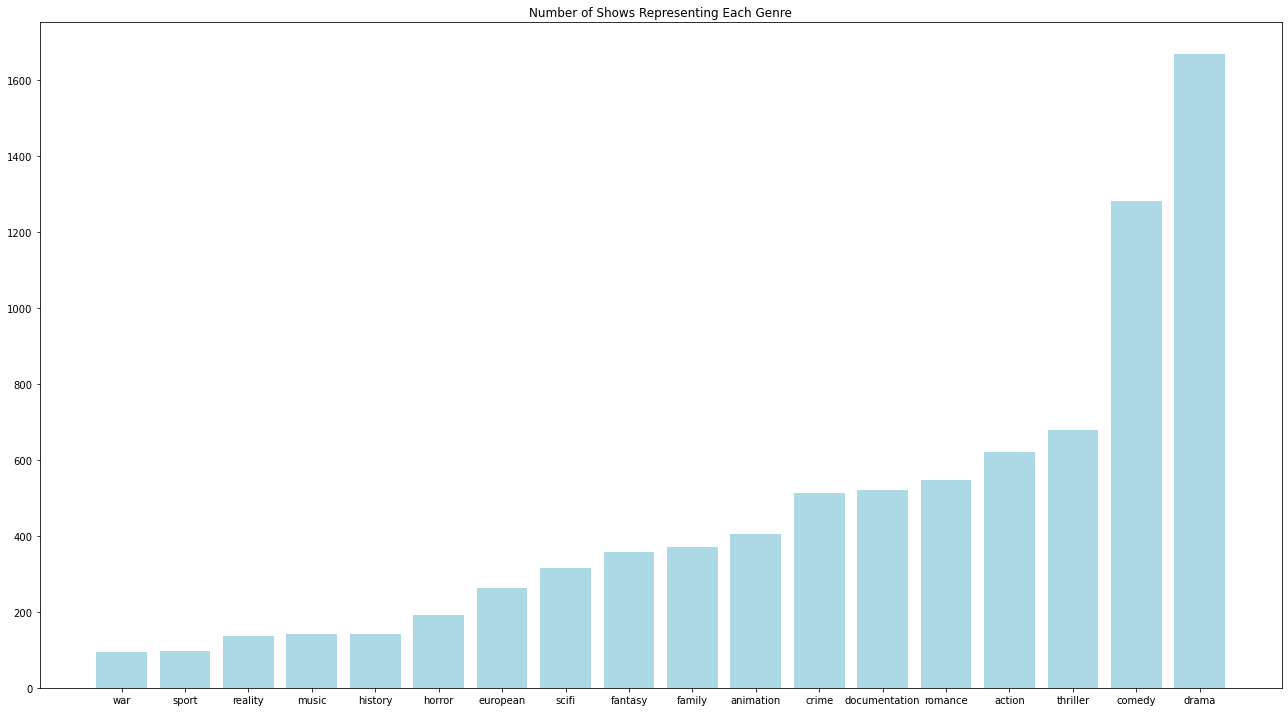

In [3]:
# get distribution of genres
e.shows_per_gen(train, gen_set)

Comedy and Drama seem to be the front runners.

**How many words in each genre are unique words? (Appear only in descriptions of movies of that fall under that genre)**

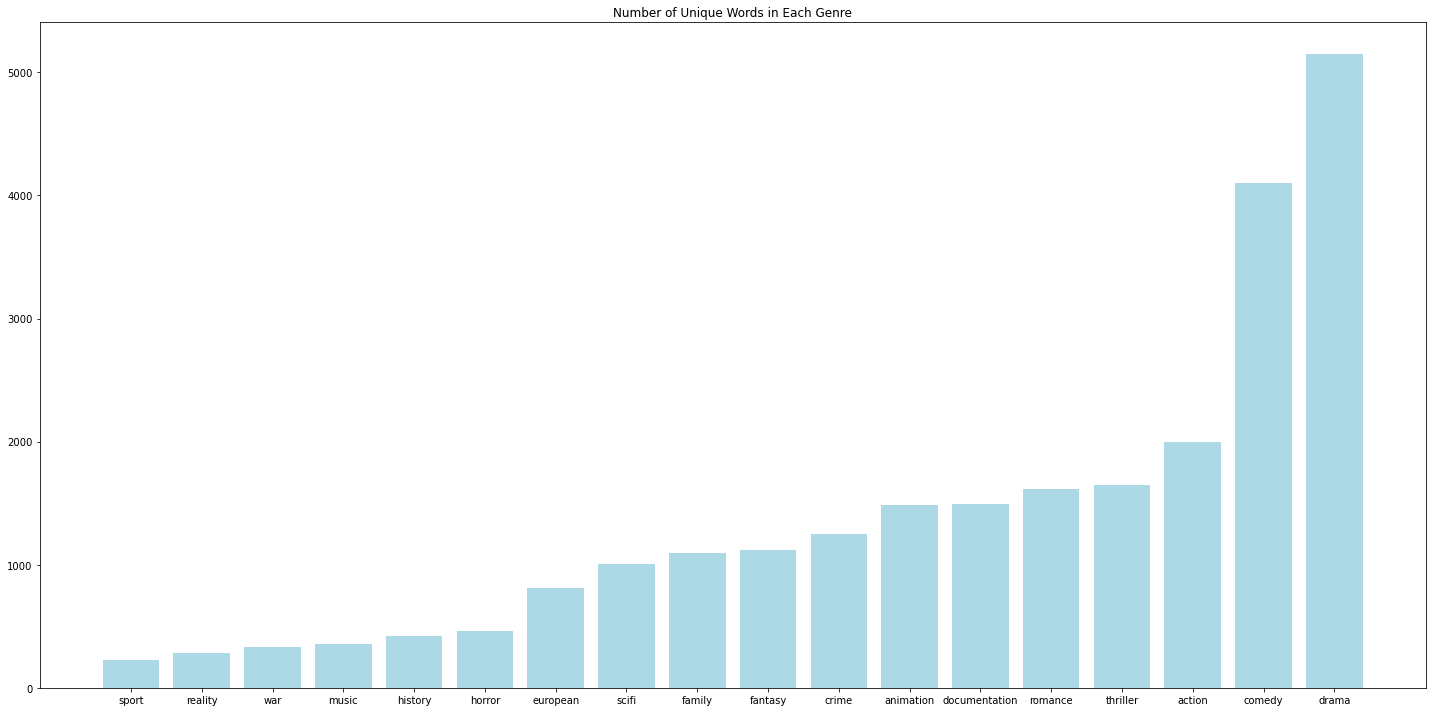

In [4]:
# get number of unique words fro each genre
e.unique_words_per_gen(train, gen_set)

Comedy and Drama seem to be the front runners for unique words as well.

**How fequently do unique words appear in each genre?**

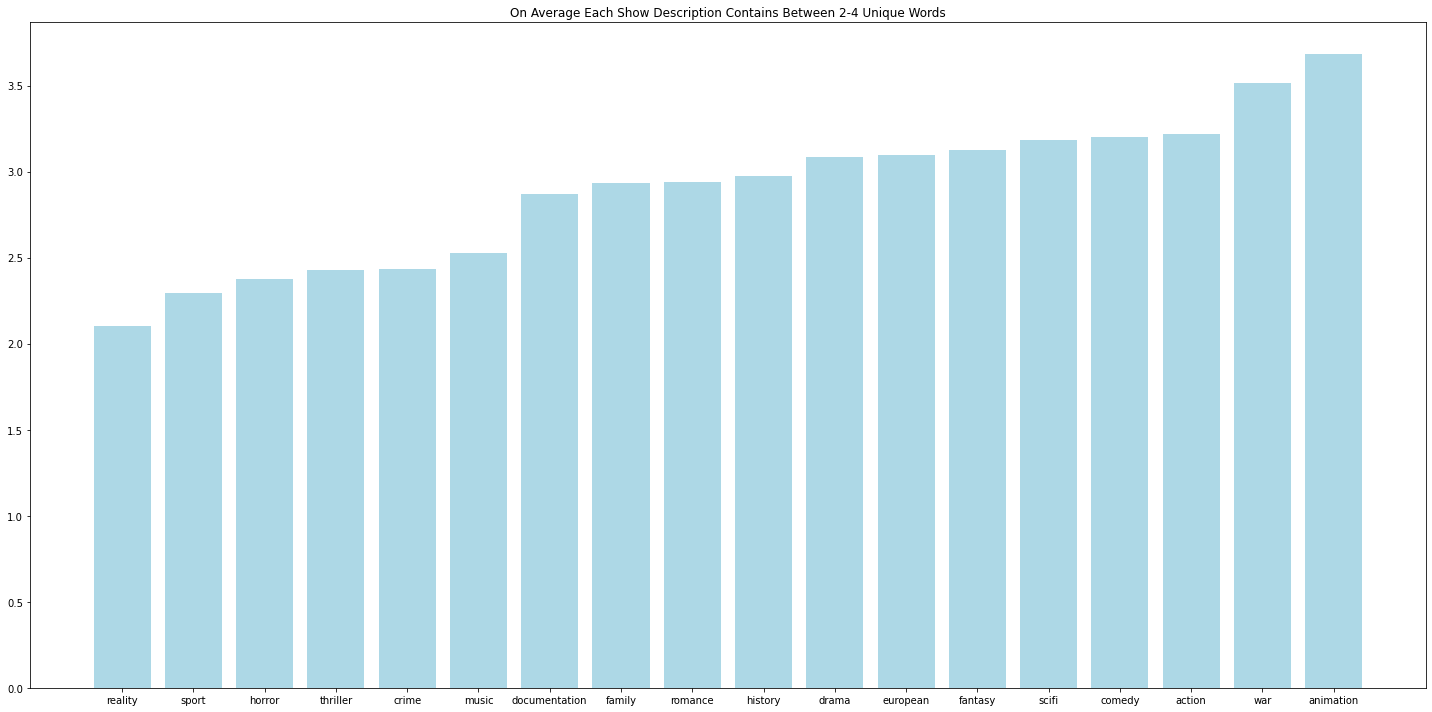

In [5]:
# get frequency of unique words pre genre
e.unique_words_frequency(train, gen_set)

Not a great deal of variance in unique word frequency. Comedy and Drama both have grater than three they were front runners in the other two criteria

**Comedy and Drama have consistantly high values in all test criteria.
Comedy seems the less vague of the two genres, by human understanding. I will choose Comedy as my test case.**

2) investigate test case (Comedy) and see how it compares to the rest of the data.

What percent of the data is classified as a Comedy?
Are there any words that appear frequently across comedy and non-comedy show descriptions